In [1]:
# notebook last tested with abtem version 1.0.0beta13

from abtem import __version__
print('current version:', __version__)

from ase.io import read
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from abtem import *

ImportError: DLL load failed while importing pyfftw: Det angivne modul blev ikke fundet.

# PACBED thickness series

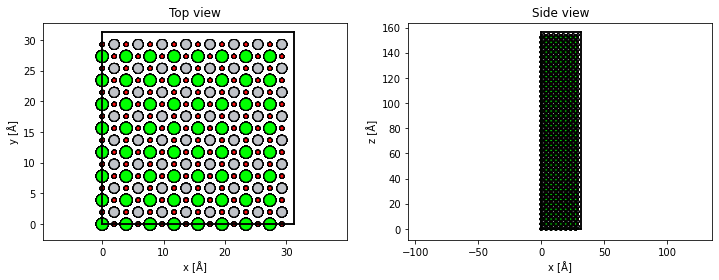

In [2]:
atoms = read('../data/srtio3_100.cif')

atoms *= (8, 8, 40)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

show_atoms(atoms, ax=ax1, title='Top view')
show_atoms(atoms, ax=ax2, plane='xz', title='Side view');

In [19]:
potential = Potential(atoms, 
                      gpts=512, 
                      device='gpu', 
                      projection='infinite', 
                      slice_thickness=atoms.cell[2,2] / 80, 
                      parametrization='kirkland')

In [4]:
detector = PixelatedDetector(max_angle=60)

end = (potential.extent[0] / 8, potential.extent[1] / 8)
scan = GridScan(start=[0, 0], end=end, sampling=.2)

probe = SMatrix(energy=80e3, semiangle_cutoff=20, device='gpu')
probe.grid.match(potential)

In [5]:
# save after every eighth slice
save_every = 8

chunks = [(i, i + save_every) for i in range(0, len(potential), save_every)] 

In [24]:
measurements = []

S = probe.build()
for i, j in tqdm(chunks):
    
    potential_slices = potential[i:j]
    
    S.multislice(potential_slices, multislice_pbar=False, plane_waves_pbar=False)
    
    measurement = S.scan(scan, detector, pbar=False)
    
    measurements.append(measurement.sum((0,1)))

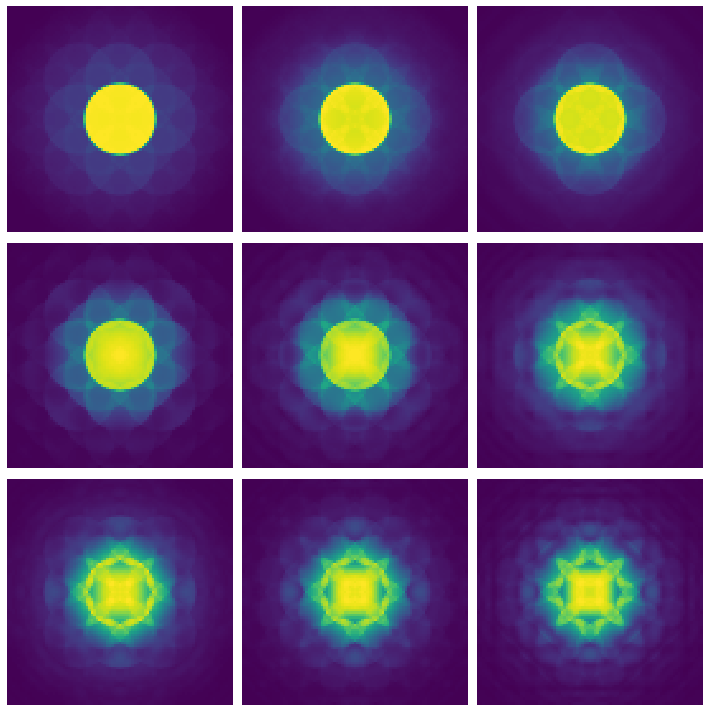

In [25]:
fig, axes = plt.subplots(3,3, figsize=(10,10))

for i, ax in enumerate(axes.ravel()):
    measurements[i].show(ax=ax, cmap='viridis', power=.5)
    ax.axis('off')

plt.tight_layout()